In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


In [28]:
# Compute a "true" reference covariance matrix
num_images = 4000
num_patches = 4000
edge_crop = 32
channel = 'LED119'
ev_floor = 1e-4
key = jax.random.PRNGKey(0)

patch_sizes = [2, 4, 6, 8, 10]
patch_sizes = [2, 3, 4, 5, 6]

images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)

cov_mats_stationary_pd = {}
means = {}
patches_by_size = {}
print('loading patches')
patches = extract_patches(images, onp.max(patch_sizes), num_patches=num_patches)

for patch_size in tqdm(patch_sizes):
    if patch_size == onp.max(patch_sizes):
        patches = patches_by_size[patch_size]
    else:
        # draw subpatches from the larger patches
        offsets = jax.random.randint(key, (num_patches, 2), 0, onp.max(patch_sizes) - patch_size)
        key, subkey = jax.random.split(key)
        subpatches = []
        for i in range(num_patches):
            subpatches.append(patches[i, offsets[i, 0]:offsets[i, 0] + patch_size, offsets[i, 1]:offsets[i, 1] + patch_size])
        patches_by_size[patch_size] = np.array(subpatches)

print('computing cov mats')
for patch_size in tqdm(patch_sizes):
    patches = patches_by_size[patch_size]
    # cov_mat = compute_cov_mat(patches)
    # cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=ev_floor, show_plot=False)
    cov_mat_stationary = compute_stationary_cov_mat(patches)
    cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=ev_floor, show_plot=False)
    means[patch_size] = np.mean(patches)
    cov_mats_stationary_pd[patch_size] = cov_mat_stationary_pd
    

loading patches


 80%|████████  | 4/5 [02:10<00:32, 32.66s/it]


KeyError: 6

In [15]:

# verify that direct likelihood and iterative likelihood are the same
patch_size_to_test = 6


test_patch = patches_by_size[patch_size_to_test][0]
samples = test_patch.reshape(-1, test_patch.shape[-2], test_patch.shape[-1])


cov_mat = cov_mats_stationary_pd[patch_size_to_test]
# cov_mat = np.eye(cov_mat.shape[0])
mean = means[patch_size_to_test]

direct = []
for sample in tqdm(samples):
    direct.append(jax.scipy.stats.multivariate_normal.logpdf(sample.reshape(-1), mean=mean * np.ones(cov_mat.shape[0]), cov=cov_mat))
direct = np.array(direct)

function_iterative = compute_stationary_log_likelihood(samples, cov_mat, mean, prefer_iterative=True)

print('direct', direct)
print('function_iterative', function_iterative)

precomputing masks and variances:  17%|█▋        | 1/6 [00:00<00:01,  4.52it/s]

[[15658.26554668]]
[[1277.77175145]]
[[626.81791312]]
[[626.81604429]]
[[597.83390942]]
[[590.60709981]]


precomputing masks and variances:  33%|███▎      | 2/6 [00:00<00:00,  5.11it/s]

[[1560.05259616]]
[[355.74399719]]
[[304.28371773]]
[[298.15949931]]
[[296.79986046]]
[[320.12301013]]
[[853.94821175]]


precomputing masks and variances:  50%|█████     | 3/6 [00:00<00:00,  5.19it/s]

[[270.47808301]]
[[230.38133979]]
[[226.75086572]]
[[235.1087749]]
[[283.83478948]]
[[794.26409936]]
[[258.48227887]]


precomputing masks and variances:  67%|██████▋   | 4/6 [00:00<00:00,  5.33it/s]

[[216.76676511]]
[[213.9646451]]
[[221.53195456]]
[[276.01223285]]
[[788.49781905]]
[[254.66449077]]
[[212.58107137]]


precomputing masks and variances:  83%|████████▎ | 5/6 [00:00<00:00,  5.29it/s]

[[211.1630615]]
[[217.16986617]]
[[272.02751985]]
[[772.05310363]]
[[253.2648911]]
[[210.91438953]]
[[209.81250913]]


precomputing masks and variances: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


[[215.68371982]]
[[271.18545223]]
evaluating likelihood


computing log likelihoods: 100%|██████████| 6/6 [00:00<00:00,  7.62it/s]

[[[-6.17017211 -4.85552087 -4.362287   -4.14930799 -4.13341664
   -4.11070657]
  [-4.66012765 -3.87346873 -3.82208399 -3.78726059 -3.79171604
   -3.80997483]
  [-4.47776462 -3.72133705 -3.85449884 -3.64970718 -3.87973111
   -3.75218583]
  [-4.44147522 -3.69670801 -3.6150075  -4.65311928 -5.6165744
   -3.73832315]
  [-9.22185202 -5.25214502 -3.6025772  -4.22824985 -3.60991193
   -3.75420268]
  [-4.2862194  -4.71058275 -3.62502964 -3.63871199 -7.69835117
   -3.74019649]]]
direct [-157.99050534]
function_iterative [-157.99050534]


## Compare the likelihood of stationary models trained on different patch sizes on the same data

precomputing masks and variances: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 6/6 [00:00<00:00,  7.44it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 6/6 [00:00<00:00, 10.17it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 6/6 [00:00<00:00, 17.46it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 6/6 [00:00<00:00, 255.95it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 6/6 [00:00<00:00, 284.97it/s]


Text(0.5, 0, 'Patch size')

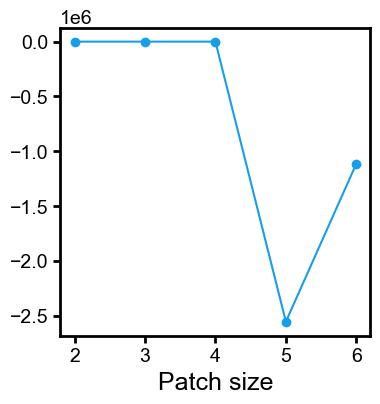

In [179]:
from image_utils import *

# TODO change to a proper test set
test_patches = patches_by_size[patch_sizes[-1]][:100]

log_likelihoods = []
for patch_size in patch_sizes:
    # test_patches = patches_by_size[patch_size][:100]
    cov_mat = cov_mats_stationary_pd[patch_size]
    mean = means[patch_size]
    ll  = compute_stationary_log_likelihood(test_patches, cov_mat, mean, prefer_iterative=False)
    log_likelihoods.append(ll)


# plot mean log likelihood vs patch size
plt.figure(figsize=(4, 4))
plt.plot(patch_sizes, [np.mean(l) for l in log_likelihoods], 'o-')
plt.xlabel('Patch size')




Text(0.5, 0, 'Patch size')

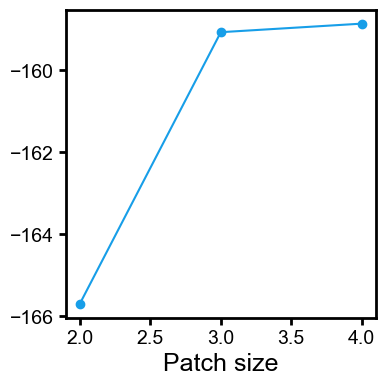

In [180]:
# plot mean log likelihood vs patch size
plt.figure(figsize=(4, 4))
plt.plot(patch_sizes[:3], [np.mean(l) for l in log_likelihoods][:3], 'o-')
plt.xlabel('Patch size')


15683.109207727592
396.12779487416896
15910.63388547364
395.4144676900561
16040.229549591091
392.6101488624934


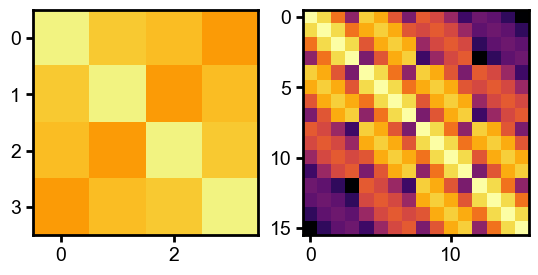

In [166]:
# imshow both cov mats with the same contrast
vmin, vmax = cov_mats_stationary_pd[4].min(), cov_mats_stationary_pd[4].max()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cov_mats_stationary_pd[patch_sizes[0]], vmin=vmin, vmax=vmax, cmap='inferno')
axs[1].imshow(cov_mats_stationary_pd[patch_sizes[1]], vmin=vmin, vmax=vmax, cmap='inferno')

for patch_size in patch_sizes:
    print(cov_mats_stationary_pd[patch_size][0,0])
    # print mean
    print(means[patch_size])